In [1]:
# Import OS libraries
import os
import json
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# Import OS libraries
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold

In [3]:
# Import OS libraries
import os
import itertools

# Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report


# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

# from googleapiclient.discovery import build
# from google.oauth2.credentials import Credentials
# from googleapiclient.http import MediaFileUpload

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


# Check GPU availability
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

sns.set_style('whitegrid')

GPU is not available


In [4]:
# Directory where images are stored without being separated by folders
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [5]:
#load image, resize, normalise and convert 
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  
        return np.array(image) / 255.0  
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [6]:
# Load training group IDs from a text file
train_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\vague_train.txt'
with open(train_ids_file, 'r') as file:
    train_ids = [str(id) for id in json.loads(file.read())]

In [7]:
# Load validation group IDs from a text file
val_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\vague_val.txt'
with open(val_ids_file, 'r') as file:
    val_ids = [str(id) for id in json.loads(file.read())]

In [8]:
# Check that the IDs have been loaded correctly
print(f"IDs de treinamento carregados: {train_ids[:5]} ... ({len(train_ids)} no total)")
print(f"IDs de validação carregados: {val_ids[:5]} ... ({len(val_ids)} no total)")

IDs de treinamento carregados: ['11829', '11828', '11825', '11824', '11827'] ... (644 no total)
IDs de validação carregados: ['12480', '12395', '12486', '12485', '12236'] ... (215 no total)


In [9]:
%%capture
# Lists for storing image paths and corresponding labels
train_data = []
val_data = []

# Iterate over all the files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue
        
        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue
        
        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue
        
        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [10]:
# Check the number of images uploaded
print(f"Número de imagens de treinamento carregadas: {len(train_data)}")
print(f"Número de imagens de validação carregadas: {len(val_data)}")

Número de imagens de treinamento carregadas: 642
Número de imagens de validação carregadas: 214


In [11]:
train_images = [data[0] for data in train_data]
train_labels = [data[1] for data in train_data]

In [12]:
# Separate images and labels for validation
val_images = [data[0] for data in val_data]
val_labels = [data[1] for data in val_data]

In [13]:
# Check if the lists are empty
if len(train_images) == 0:
    print("Nenhuma imagem de treinamento foi carregada.")
if len(val_images) == 0:
    print("Nenhuma imagem de validação foi carregada.")

In [14]:
# Filter valid image paths
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [15]:
# Convert the images into tensors and normalise if necessary
train_images = [load_image(image_path, target_size=(112, 112)) for image_path in train_images]
val_images = [load_image(image_path, target_size=(112, 112)) for image_path in val_images]

In [16]:
# Check if an image has failed to load
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [17]:
# Check the shape of images and labels before coding
print("Shape de train_images antes da codificação:", np.array(train_images).shape)
print("Shape de train_labels antes da codificação:", np.array(train_labels).shape)
print("Shape de val_images antes da codificação:", np.array(val_images).shape)
print("Shape de val_labels antes da codificação:", np.array(val_labels).shape)

Shape de train_images antes da codificação: (642, 112, 112, 3)
Shape de train_labels antes da codificação: (642,)
Shape de val_images antes da codificação: (214, 112, 112, 3)
Shape de val_labels antes da codificação: (214,)


In [ ]:
def check_image_shapes(image_list):
    for i, img in enumerate(image_list):
        if not isinstance(img, np.ndarray):
            print(f"Item at index {i} is not a numpy array.")
            return False
        if img.shape != (224, 224, 3):
            print(f"Image at index {i} has shape {img.shape} instead of (112, 112, 3).")
            return False
    return True

# Check shapes of training images
train_images_valid = check_image_shapes(train_images)
print(f"Todas as imagens de treinamento têm a forma correta: {train_images_valid}")

# Check shapes of validation images
val_images_valid = check_image_shapes(val_images)
print(f"Todas as imagens de validação têm a forma correta: {val_images_valid}")

In [20]:
# Convert the labels to the appropriate (numeric) format, if necessary
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [21]:
# Check the number of classes
num_classes = len(label_encoder.classes_)
print(f"Número de classes: {num_classes}")


Número de classes: 3


In [22]:
# One-hot encoding of labels after splitting
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

# Verificar os shapes dos rótulos one-hot encoded
print("Shape de train_labels_one_hot após o one-hot encoding:", train_labels_one_hot.shape)
print("Shape de val_labels_one_hot após o one-hot encoding:", val_labels_one_hot.shape)

Shape de train_labels_one_hot após o one-hot encoding: (642, 3)
Shape de val_labels_one_hot após o one-hot encoding: (214, 3)


In [23]:
#create the cnn model 
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(112, 112, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

In [24]:
#compile the model 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
import numpy as np

#check data dimensions 
print("Shape de train_images:", np.array(train_images).shape)
print("Shape de train_labels_one_hot:", train_labels_one_hot.shape)
print("Shape de val_images:", np.array(val_images).shape)
print("Shape de val_labels_one_hot:", val_labels_one_hot.shape)


Shape de train_images: (642, 112, 112, 3)
Shape de train_labels_one_hot: (642, 3)
Shape de val_images: (214, 112, 112, 3)
Shape de val_labels_one_hot: (214, 3)


In [26]:
#train  the model
history = model.fit(
    np.array(train_images), 
    train_labels_one_hot, 
    epochs=20, 
    batch_size=32, 
    validation_data=(np.array(val_images), val_labels_one_hot)
)

Epoch 1/20
21/21 [==============================] - 12s 462ms/step - loss: 0.9805 - accuracy: 0.4984 - val_loss: 0.8897 - val_accuracy: 0.7383
Epoch 2/20
21/21 [==============================] - 9s 423ms/step - loss: 0.8261 - accuracy: 0.6682 - val_loss: 0.7886 - val_accuracy: 0.6168
Epoch 3/20
21/21 [==============================] - 9s 429ms/step - loss: 0.6997 - accuracy: 0.7492 - val_loss: 0.6330 - val_accuracy: 0.7477
Epoch 4/20
21/21 [==============================] - 8s 389ms/step - loss: 0.6208 - accuracy: 0.7804 - val_loss: 0.5818 - val_accuracy: 0.8224
Epoch 5/20
21/21 [==============================] - 9s 441ms/step - loss: 0.6224 - accuracy: 0.7773 - val_loss: 0.5799 - val_accuracy: 0.8318
Epoch 6/20
21/21 [==============================] - 9s 410ms/step - loss: 0.6654 - accuracy: 0.7461 - val_loss: 0.5743 - val_accuracy: 0.8178
Epoch 7/20
21/21 [==============================] - 9s 442ms/step - loss: 0.5976 - accuracy: 0.7928 - val_loss: 0.5010 - val_accuracy: 0.8224
Epoch

In [27]:
# Evaluate in the validation set
val_loss, val_accuracy = model.evaluate(np.array(val_images), val_labels_one_hot)
print(f"Loss no conjunto de validação: {val_loss}")
print(f"Accuracy no conjunto de validação: {val_accuracy}")

7/7 [==============================] - 1s 71ms/step - loss: 0.3357 - accuracy: 0.8785
Loss no conjunto de validação: 0.3356505334377289
Accuracy no conjunto de validação: 0.8785046935081482


7/7 [==============================] - 1s 83ms/step


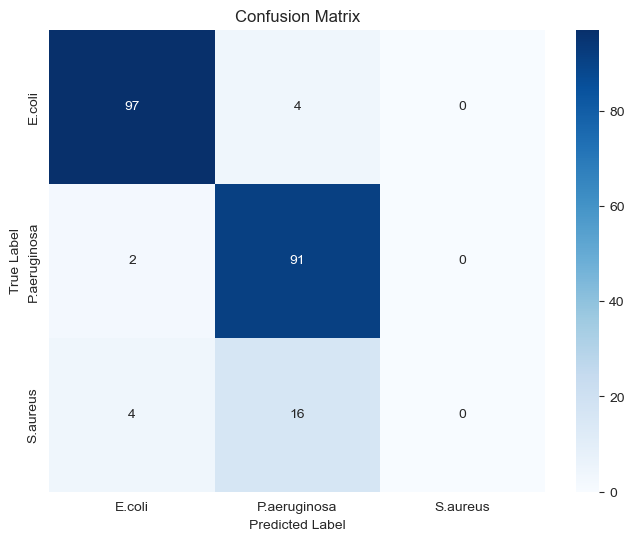

Relatório de Classificação:
               precision    recall  f1-score   support

      E.coli       0.94      0.96      0.95       101
P.aeruginosa       0.82      0.98      0.89        93
    S.aureus       0.00      0.00      0.00        20

    accuracy                           0.88       214
   macro avg       0.59      0.65      0.61       214
weighted avg       0.80      0.88      0.84       214



In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions from the model
val_predictions = model.predict(np.array(val_images))

# Convert predictions back to labels (classes)
val_pred_labels = np.argmax(val_predictions, axis=1)

# Convert the actual one-hot encoded labels back to labels
val_true_labels = np.argmax(val_labels_one_hot, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Ensure that class labels are strings
target_names = [str(class_name) for class_name in label_encoder.classes_]

# Display the classification report for more details
print("Relatório de Classificação:\n", classification_report(val_true_labels, val_pred_labels, target_names=target_names))



In [33]:
# Example of how to extract class names from uploaded JSON data
for data in train_data[:5]:  # Showing the first 5 instances
    print(f"Path da Imagem: {data[0]}, Classe: {data[1]}")

Path da Imagem: C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset\11762.jpg, Classe: P.aeruginosa
Path da Imagem: C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset\11763.jpg, Classe: P.aeruginosa
Path da Imagem: C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset\11764.jpg, Classe: P.aeruginosa
Path da Imagem: C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset\11765.jpg, Classe: P.aeruginosa
Path da Imagem: C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset\11766.jpg, Classe: P.aeruginosa


In [34]:
# Updating the LabelEncoder with the names of the bacteria
bacterial_labels = [data[1] for data in train_data]  # Usando os rótulos com nomes das bactérias
label_encoder = LabelEncoder()
label_encoder.fit(bacterial_labels)

# Check the correct correspondence
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Classe {i}: {class_name}")

Classe 0: E.coli
Classe 1: P.aeruginosa
Classe 2: S.aureus


In [31]:
#save the model
model.save('trained_model.vague')

INFO:tensorflow:Assets written to: trained_model.vague\assets


INFO:tensorflow:Assets written to: trained_model.vague\assets


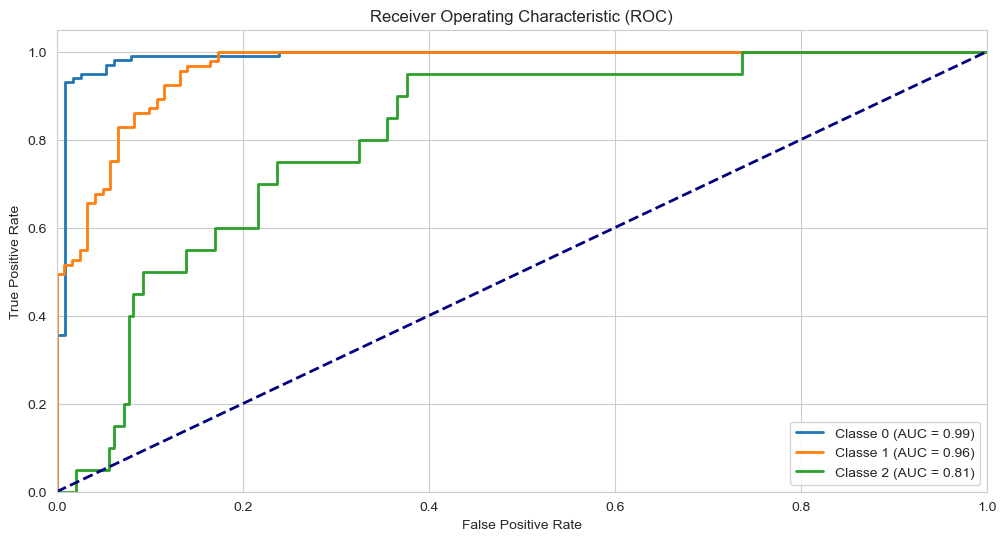

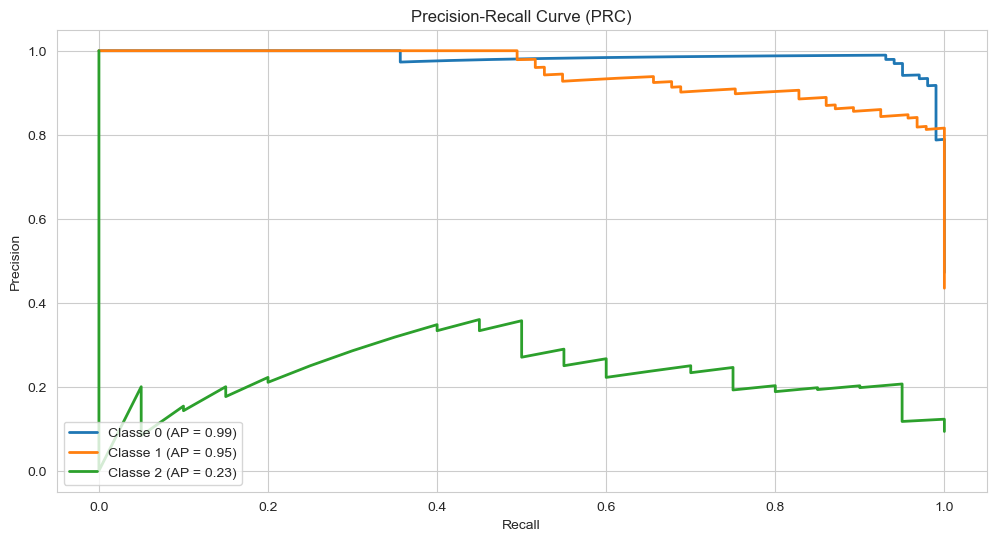

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np

# Ensure you have the number of classes defined
num_classes = len(label_encoder.classes_)

# Use the one-hot encoded labels directly
val_labels_binarized = val_labels_one_hot

# Use the predictions you've already computed
val_predictions_binarized = val_predictions  # Ensure val_predictions is defined

# Create ROC curve for all classes
plt.figure(figsize=(12, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(val_labels_binarized[:, i], val_predictions_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Create Precision-Recall curve for all classes
plt.figure(figsize=(12, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels_binarized[:, i], val_predictions_binarized[:, i])
    average_precision = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'Classe {i} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PRC)')
plt.legend(loc='lower left')
plt.show()